Business Understanding:

Topik yang dipilih pada proyek akhir ini adalah pilpers 2024. Alasan dipilihnya topik ini dikarenakan pelaksanaan pilpres yang akan berlangsung 2 tahun mendatang sudah menimbulkan banyak pergerakan dari berbagai tokoh maupun partai politik yang kemudian memicu masyarakat untuk mengeluarkan opininya. Hal yang nanti akan dicari adalah kata kunci yang sering dibicarakan serta tentunya sentimen masyarakat saat ini terhadap berbagai wacana terkait pilpres 2024 dengan tujuan untuk mengetahui optimisme masyarakat akan pelaksanaan pilpres 2024.

In [1]:
# Library dan package yang dipakai
import json, tweepy, datetime, pandas as pd, re, string, nltk, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from urllib.request import urlopen
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rayendra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rayendra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Data Collection:

In [2]:
# Akses ke API twitter
with open('token.json')as f:
    tokens = json.load(f)

api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
bearer_token = tokens['bearer_token']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

access = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

In [3]:
# Mengambil tweet terkait topik pilpres 2024 dari twitter dalam 3 hari terakhir
finish= datetime.datetime.now() - datetime.timedelta(hours=8)
begin = finish - datetime.timedelta(3)
tweets = tweepy.Paginator(access.search_recent_tweets, query='pilpres 2024 -is:retweet lang:id', 
                          tweet_fields=['created_at'], start_time=begin, end_time=finish).flatten(limit=5000)
tweets = [[tweet.created_at, tweet.text.strip()] for tweet in tweets]
df_tweets = pd.DataFrame(tweets, columns=['date', 'tweet'])
df_tweets['date'] = df_tweets['date'].dt.strftime('%m-%d-%Y')
df_tweets

,date,tweet
0,06-26-2022,Elite NU meyakini Puan Maharani menjadi kandid...
1,06-26-2022,Wanti-wanti Fahri Hamzah 8 Bulan Jeda Menuju P...
2,06-26-2022,Rempuni Cirebon melakukan deklarasi mendukung ...
3,06-26-2022,Fahri Hamzah Ungkap Kekhawatiran Soal Jeda Has...
4,06-26-2022,Cocok sih sama² ambisi gede 😁😁\nDan memenuhi s...
...,...,...
1734,06-23-2022,"Bertemu AHY, NasDem: Kami Sadar Harus Bergande..."
1735,06-23-2022,@RenaldiCicko @ganjarpranowo @pungky1981 @fasy...
1736,06-23-2022,"Pilih Istilah Kerja Sama di Pilpres 2024, Sekj..."
1737,06-23-2022,"PKS Kunjungi Nasdem, Pengamat Politik Sebut Na..."


In [4]:
# Mengambil berita terkait topik pilpres 2024 dari google news dalam 3 hari terakhir
html = urlopen('https://news.google.com/search?q=pilpres%202024%20when%3A3d&hl=id')
data = BeautifulSoup(html, 'html.parser')
news = data.findAll('a', {'class':'DY5T1d RZIKme'})
df_news = pd.DataFrame(news, columns=['news'])
df_news

,news
0,JK Prediksi Empat Poros di Pilpres 2024
1,M. Qodari Sebut 3 Nama Ini Berpeluang Besar Mu...
2,Politisi Partai Perindo Prediksi 3 Pasangan Ca...
3,Pengamat Bicara Peluang Duet Prabowo - AHY di ...
4,Peta Koalisi Terbaru: Bisa Ada 4 Capres di Pil...
...,...
94,Siapa Pendamping Anies Baswedan 2024? - Kompas...
95,Pengamat Politik: Ada Rivalitas Diam-diam Mega...
96,"Golkar Yakin Airlangga Menang Pilpres, Asalkan..."
97,Gerakan Nelayan Probolinggo Deklarasi Dukung P...


In [5]:
# Menggabungkan dataframe twitter dan dataframe google news
df_tweets.drop('date', inplace=True, axis=1)
df_tweets.rename(columns={'tweet':'teks'}, inplace=True)
df_news.rename(columns={'news':'teks'}, inplace=True)
df_pilpres = pd.concat([df_tweets, df_news], ignore_index=True)
df_pilpres

,teks
0,Elite NU meyakini Puan Maharani menjadi kandid...
1,Wanti-wanti Fahri Hamzah 8 Bulan Jeda Menuju P...
2,Rempuni Cirebon melakukan deklarasi mendukung ...
3,Fahri Hamzah Ungkap Kekhawatiran Soal Jeda Has...
4,Cocok sih sama² ambisi gede 😁😁\nDan memenuhi s...
...,...
1833,Siapa Pendamping Anies Baswedan 2024? - Kompas...
1834,Pengamat Politik: Ada Rivalitas Diam-diam Mega...
1835,"Golkar Yakin Airlangga Menang Pilpres, Asalkan..."
1836,Gerakan Nelayan Probolinggo Deklarasi Dukung P...


Data Analisis:

In [6]:
# Melihat ringkasan singkat dataframe pilpres
df_pilpres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838 entries, 0 to 1837
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    1838 non-null   object
dtypes: object(1)
memory usage: 14.5+ KB


In [7]:
# Melihat hasil statistik deskriptif dataframe pilpres
df_pilpres.describe()

,teks
count,1838
unique,1781
top,"pernah ktmu bapak ini thn 2019 wkt di depok,, ..."
freq,5


In [8]:
# Melihat jumlah karakter yang ada dalam teks dataframe pilpres 
jumlah_karakter = df_pilpres['teks'].str.len()
jumlah_karakter = jumlah_karakter.rename_axis('Indeks Teks').to_frame('Jumlah Karakter')
jumlah_karakter.describe().loc[['max', 'min', 'mean']]

,Jumlah Karakter
max,856.000000
min,24.000000
mean,156.287813


In [9]:
# Melihat jumlah kata yang ada dalam teks dataframe pilpres
jumlah_kata = df_pilpres['teks'].str.split().map(lambda x: len(x))
jumlah_kata = jumlah_kata.rename_axis('Indeks Teks').to_frame('Jumlah Kata')
jumlah_kata.describe().loc[['max', 'min', 'mean']]

,Jumlah Kata
max,85.000000
min,3.000000
mean,19.915669


Data Preprocessing:

In [10]:
# Menghapus baris yang terduplikasi atau memiliki nilai identik pada dataframe pilpres
df_pilpres = df_pilpres.drop_duplicates()
df_pilpres

,teks
0,Elite NU meyakini Puan Maharani menjadi kandid...
1,Wanti-wanti Fahri Hamzah 8 Bulan Jeda Menuju P...
2,Rempuni Cirebon melakukan deklarasi mendukung ...
3,Fahri Hamzah Ungkap Kekhawatiran Soal Jeda Has...
4,Cocok sih sama² ambisi gede 😁😁\nDan memenuhi s...
...,...
1833,Siapa Pendamping Anies Baswedan 2024? - Kompas...
1834,Pengamat Politik: Ada Rivalitas Diam-diam Mega...
1835,"Golkar Yakin Airlangga Menang Pilpres, Asalkan..."
1836,Gerakan Nelayan Probolinggo Deklarasi Dukung P...


In [11]:
# Perintah atau function yang digunakan untuk melakukan preprocessing dataframe pilpres
slang_word = {'slang':['blm', 'blum', 'bkn', 'bkan', 'enggk', 'gk', 'jngn', 'jngan', 'lwn', 'lwan', 'tdk', 'tdak', 'tngkat', 'trn', 'trun', 'bhw', 'bhwa', 'mnang', 'klh', 'klah', 'utk', 'untk', 'ykn', 'ykin', 'dmpk', 'dmpak', 'brk', 'bruk', 'crng', 'crang', 'jjr', 'jjur', 'spt', 'sprt', 'sprti', 'seprti', 'yg', 'sngkta', 'sngketa', 'kpd', 'kpda', 'bgs', 'bgus', 'bhng', 'bhong', 'sdngkn', 'sdngkan', 'wlpn', 'wlpun', 'sbntr', 'sbntar', 'kmrn', 'knp', 'msh', 'msih', 'jd', 'jdi', 'krn', 'krena', 'sblm', 'sblum', 'pgn', 'tlpn', 'gapapa', 'gpp', 'tp', 'jg', 'jlk', 'jlek', 'kcw', 'kcwa', 'mrh', 'mrah', 'mls', 'mlas', 'pstf', 'pstif', 'ngtf', 'ngtif', 'klo', 'klw', 'lbh', 'lbih', 'sdih', 'bngung', 'snang', 'bhgia', 'trs', 'trus', 'krng', 'krang', 'tmbh', 'tmbah', 'ktmu', 'thn', 'thun', 'wkt', 'wktu', 'bgm'],
              'replace':['belum', 'belum', 'bukan', 'bukan', 'enggak', 'gak', 'jangan', 'jangan', 'lawan', 'lawan', 'tidak', 'tidak', 'tingkat', 'turun', 'turun', 'bahwa', 'bahwa', 'menang', 'kalah', 'kalah', 'untuk', 'untuk', 'yakin', 'yakin', 'dampak', 'dampak', 'buruk', 'buruk', 'curang', 'curang', 'jujur', 'jujur', 'seperti', 'seperti', 'seperti', 'seperti', 'yang', 'sengketa', 'sengketa', 'kepada', 'kepada', 'bagus', 'bagus', 'bohong', 'bohong', 'sedangkan', 'sedangkan', 'walaupun', 'walaupun', 'sebentar', 'sebentar', 'kemarin', 'kenapa', 'masih', 'masih', 'jadi', 'jadi', 'karena', 'karena', 'sebelum', 'sebelum', 'pengen', 'telepon', 'gak apa apa', 'gak apa apa', 'tapi', 'juga', 'jelek', 'jelek', 'kecewa', 'kecewa', 'marah', 'marah', 'malas', 'malas', 'positif', 'positif', 'negatif', 'negatif', 'kalau', 'kalau', 'lebih', 'lebih', 'sedih', 'bingung', 'senang', 'bahagia', 'terus', 'terus', 'kurang', 'kurang', 'tambah', 'tambah', 'ketemu', 'tahun', 'tahun', 'waktu', 'waktu', 'bagaimana']}
slang_word = dict(zip(slang_word['slang'], slang_word['replace']))

def casefolding(teks):
  teks = teks.lower()
  teks = re.sub(r'(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|(\d+)', ' ', teks)
  teks = teks.translate(str.maketrans('', '', string.punctuation))
  teks = re.sub(r'^https?:\/\/.*[\r\n]*', '', teks, flags=re.MULTILINE)
  teks = teks.strip()
  return teks

def stopword(teks):
  id_stopword = stopwords.words('indonesian')
  more_stopword = ['pilpres', '2024']
  teks = teks.split()
  teks = [word for word in teks if word not in id_stopword and word not in more_stopword]
  teks = ' '.join(teks)
  return teks

In [12]:
# Melakukan preprocessing dataframe pilpress
df_pilpres = df_pilpres.copy()
df_pilpres['teks_bersih'] = df_pilpres['teks'].replace(slang_word, regex=True)
df_pilpres['teks_bersih'] = df_pilpres['teks_bersih'].apply(casefolding)
df_pilpres['teks_bersih'] = df_pilpres['teks_bersih'].apply(stopword)
df_pilpres

,teks,teks_bersih
0,Elite NU meyakini Puan Maharani menjadi kandid...,elite nu puan maharani kandidat kuat calon pre...
1,Wanti-wanti Fahri Hamzah 8 Bulan Jeda Menuju P...,wanti wanti fahri hamzah jeda pelantikan hasil...
2,Rempuni Cirebon melakukan deklarasi mendukung ...,rempuni cirebon deklarasi mendukung puan mahar...
3,Fahri Hamzah Ungkap Kekhawatiran Soal Jeda Has...,fahri hamzah ungakap kekhawatiran jeda hasil p...
4,Cocok sih sama² ambisi gede 😁😁\nDan memenuhi s...,cocok sih ambisi gede memenuhi syarat pt progu...
...,...,...
1833,Siapa Pendamping Anies Baswedan 2024? - Kompas...,pendamping anies baswedan kompasiana com
1834,Pengamat Politik: Ada Rivalitas Diam-diam Mega...,pengamat politik rivalitas diam diam megawati ...
1835,"Golkar Yakin Airlangga Menang Pilpres, Asalkan...",golkar airlangga menang petanya
1836,Gerakan Nelayan Probolinggo Deklarasi Dukung P...,gerakan nelayan probolinggo deklarasi dukung p...


Teks Analisis:

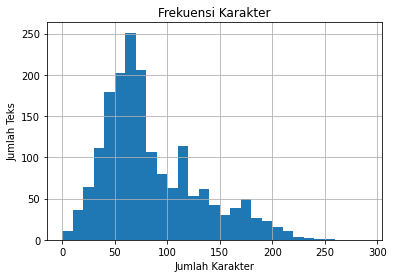

In [13]:
# Melihat frekuensi karakter pada dataframe pilpres yang sudah dibersihkan
bin_range = np.arange(0, 300, 10)
df_pilpres['teks_bersih'].str.len().hist(bins=bin_range)
plt.title('Frekuensi Karakter')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Jumlah Teks')
plt.show()

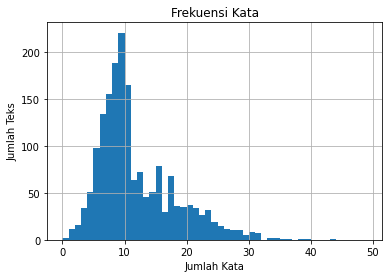

In [14]:
# Melihat frekuensi kata pada dataframe pilpres yang sudah dibersihkan
bin_range = np.arange(0, 50)
df_pilpres['teks_bersih'].str.split().map(lambda x: len(x)).hist(bins=bin_range)
plt.title('Frekuensi Kata')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Teks')
plt.show()

c:\Users\Rayendra\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Rayendra\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


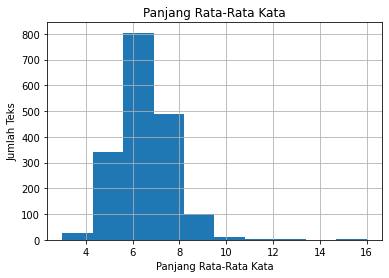

In [15]:
# Melihat panjang rata-rata kata pada dataframe pilpres yang sudah dibersihkan
df_pilpres['teks_bersih'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.title('Panjang Rata-Rata Kata')
plt.xlabel('Panjang Rata-Rata Kata')
plt.ylabel('Jumlah Teks')
plt.show()

In [16]:
# Melihat distribusi kata pada dataframe pilpres yang sudah dibersihkan
df_pilpres_token = df_pilpres['teks_bersih'].apply(lambda x: word_tokenize(str(x)))
teks = [word for teks_bersih in df_pilpres_token for word in teks_bersih]
DistFrek = FreqDist(teks)
kata_terkait = DistFrek.most_common(20)
print(kata_terkait)

[('puan', 369), ('politik', 368), ('presiden', 324), ('maju', 282), ('maharani', 270), ('pdip', 230), ('anies', 229), ('partai', 204), ('identitas', 201), ('jokowi', 178), ('erick', 175), ('thohir', 165), ('capres', 162), ('indonesia', 159), ('ganjar', 158), ('ketua', 155), ('calon', 144), ('pemilu', 133), ('koalisi', 128), ('mendukung', 120)]


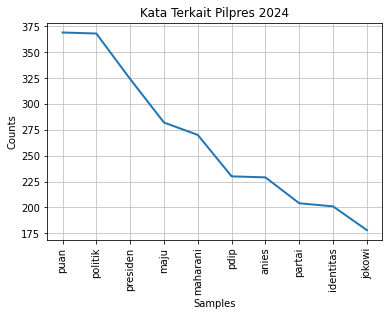

In [17]:
# Melihat 10 kata yang paling sering terkait dengan topik pilpres 2024
DistFrek.plot(10, cumulative=False, title='Kata Terkait Pilpres 2024')
plt.show()

In [18]:
# Melihat 10 pasangan kata yang paling sering terkait dengan topik pilpres 2024
bigrams = pd.Series(nltk.ngrams(teks, 2)).value_counts()[:10]
print(bigrams)

(puan, maharani)        270
(politik, identitas)    200
(erick, thohir)         165
(calon, presiden)       113
(presiden, jokowi)       78
(ketua, dpr)             77
(mendukung, puan)        72
(thohir, maju)           71
(anies, baswedan)        69
(pancasila, satukan)     66
dtype: int64


Sentimen Analisis:

In [19]:
# Menentukan sentimen dari teks yang berada pada dataframe pilpres yang sudah dibersihkan
teks = df_pilpres['teks_bersih']

with open('./kata_positif.txt', 'r') as positif_file:
    positive_words = list(set(positif_file.readlines()))
with open('./kata_negatif.txt', 'r') as negative_file:
    negative_words = list(set(negative_file.readlines()))

results = []
list_negasi = ['anti', 'belum', 'bukan', 'enggak', 'gak', 'jangan', 'lawan', 'tak', 'tidak']

for teks in teks:
  teks_bersih= teks.strip().split()
  
  good_count = 0
  bad_count = 0

  for good_word in positive_words:
    count = teks_bersih.count(good_word.strip().lower())
    if count > 0:
      if teks_bersih[teks_bersih.index(good_word.strip().lower())-1] in list_negasi:
        good_count += count
      else:
        good_count += 1

  for bad_word in negative_words:
    count = teks_bersih.count(bad_word.strip().lower())
    if count > 0:
      bad_count += count
      if bad_word.strip().lower() in teks_bersih:
        if teks_bersih[teks_bersih.index(bad_word.strip().lower())-1] in list_negasi:
          good_count +=1
        else:
          bad_count += 1
  
  results.append(good_count - bad_count)

In [20]:
# Menambahkan kolom sentimen pada dataframe pilpres
sentiments = ['positif' if sentimen > 0 else ('netral' if sentimen == 0 else 'negatif') for sentimen in results]
df_pilpres = df_pilpres.copy()
df_pilpres['sentimen'] = sentiments
df_pilpres

,teks,teks_bersih,sentimen
0,Elite NU meyakini Puan Maharani menjadi kandid...,elite nu puan maharani kandidat kuat calon pre...,positif
1,Wanti-wanti Fahri Hamzah 8 Bulan Jeda Menuju P...,wanti wanti fahri hamzah jeda pelantikan hasil...,negatif
2,Rempuni Cirebon melakukan deklarasi mendukung ...,rempuni cirebon deklarasi mendukung puan mahar...,positif
3,Fahri Hamzah Ungkap Kekhawatiran Soal Jeda Has...,fahri hamzah ungakap kekhawatiran jeda hasil p...,negatif
4,Cocok sih sama² ambisi gede 😁😁\nDan memenuhi s...,cocok sih ambisi gede memenuhi syarat pt progu...,positif
...,...,...,...
1833,Siapa Pendamping Anies Baswedan 2024? - Kompas...,pendamping anies baswedan kompasiana com,netral
1834,Pengamat Politik: Ada Rivalitas Diam-diam Mega...,pengamat politik rivalitas diam diam megawati ...,netral
1835,"Golkar Yakin Airlangga Menang Pilpres, Asalkan...",golkar airlangga menang petanya,positif
1836,Gerakan Nelayan Probolinggo Deklarasi Dukung P...,gerakan nelayan probolinggo deklarasi dukung p...,netral


In [21]:
# Melihat hasil statistik deskriptif dari sentimen yang diperoleh
print (f'''
Mean: {np.mean(results)}
Median: {np.median(results)}
quartil awal: {np.quantile(results, 0.25)}
quartil akhir: {np.quantile(results, 0.75)}
Standar deviasi: {np.std(results)}     
''')


Mean: -0.07860752386299831
Median: 0.0
quartil awal: 0.0
quartil akhir: 1.0
Standar deviasi: 1.6072887998628669     



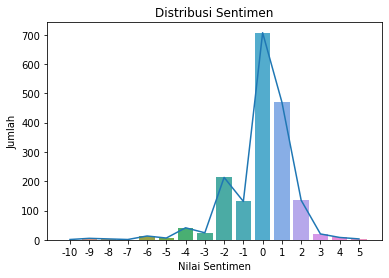

In [22]:
# Melihat distribusi sentimen berdasarkan nilainya
labels, counts = np.unique(results, return_counts=True)
fig, ax = plt.subplots()
ax.set_xticks(ax.get_xticks())
sns.barplot(x=list(labels), y=list(counts))
sns.lineplot(x=ax.get_xticks(), y=list(counts))
plt.title(f'Distribusi Sentimen')
plt.xlabel('Nilai Sentimen')
plt.ylabel('Jumlah')
plt.show()

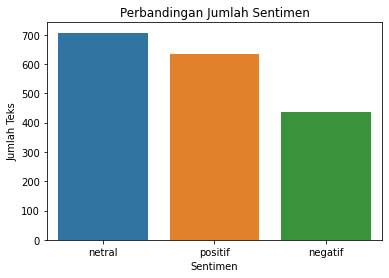

In [23]:
# Melihat perbandingan jumlah sentimen
ax = sns.barplot(x=df_pilpres['sentimen'].value_counts().index, y=df_pilpres['sentimen'].value_counts(), data=df_pilpres)
ax.set(xlabel='Sentimen', ylabel='Jumlah Teks')
plt.title('Perbandingan Jumlah Sentimen')
plt.show()

Data Processing:

In [24]:
# Menghapus kolom yang tidak dibutuhkan dan mengganti nilai sentimen dari kategorikal menjadi numerikal
df_pilpres = df_pilpres.copy()
df_pilpres.drop(columns=['teks'], inplace=True)
df_pilpres.replace({'sentimen':{'negatif':-1, 'netral':0, 'positif':1}}, inplace=True)
df_pilpres

,teks_bersih,sentimen
0,elite nu puan maharani kandidat kuat calon pre...,1
1,wanti wanti fahri hamzah jeda pelantikan hasil...,-1
2,rempuni cirebon deklarasi mendukung puan mahar...,1
3,fahri hamzah ungakap kekhawatiran jeda hasil p...,-1
4,cocok sih ambisi gede memenuhi syarat pt progu...,1
...,...,...
1833,pendamping anies baswedan kompasiana com,0
1834,pengamat politik rivalitas diam diam megawati ...,0
1835,golkar airlangga menang petanya,1
1836,gerakan nelayan probolinggo deklarasi dukung p...,0


In [25]:
# Melakukan modelling dengan naive bayes 
vectorizer = TfidfVectorizer (max_features=2500)
model_g = GaussianNB()
v_data = vectorizer.fit_transform(df_pilpres['teks_bersih']).toarray()
print(vectorizer.fit_transform(df_pilpres['teks_bersih']))

  (0, 1281)	0.26597768873405936
  (0, 402)	0.37551996178442915
  (0, 1566)	0.2348053159189625
  (0, 268)	0.30367418983317984
  (0, 835)	0.34573364054389905
  (0, 710)	0.34674569389510346
  (0, 892)	0.24689500783364723
  (0, 1596)	0.23788483887308387
  (0, 1145)	0.3575851841606719
  (0, 452)	0.39460264268484124
  (1, 763)	0.21963872442256227
  (1, 424)	0.3058883422452218
  (1, 2431)	0.31811335646200223
  (1, 557)	0.2120092323280879
  (1, 1304)	0.25067803892269186
  (1, 661)	0.25244711748320653
  (1, 544)	0.26704549503885444
  (1, 467)	0.2581765906982716
  (1, 2420)	0.6689616251563295
  (2, 981)	0.3456213229698955
  (2, 324)	0.39734164344118184
  (2, 295)	0.4482994858894391
  (2, 1684)	0.4530934439510133
  (2, 1566)	0.25661764475837706
  (2, 268)	0.3318841188237576
  :	:
  (1777, 1370)	0.17543625629865253
  (1778, 1468)	0.6451958512344491
  (1778, 518)	0.4680011926940312
  (1778, 26)	0.46326855134123535
  (1778, 966)	0.38740088606637463
  (1779, 1579)	0.4815805484502738
  (1779, 300)	0.3

In [26]:
# Menghitung matriks evaluation dengan confusion matrix
x_train, x_test, y_train, y_test = train_test_split(v_data, df_pilpres['sentimen'], test_size=0.2, random_state=62)
model_g.fit(x_train, y_train)
y_pred = model_g.predict(x_test)
print(confusion_matrix(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))
print('Nilai akurasinya adalah',accuracy_score(y_test, y_pred))

[[78 11  9]
 [24 80 39]
 [ 9 17 90]] 

              precision    recall  f1-score   support

          -1       0.70      0.80      0.75        98
           0       0.74      0.56      0.64       143
           1       0.65      0.78      0.71       116

    accuracy                           0.69       357
   macro avg       0.70      0.71      0.70       357
weighted avg       0.70      0.69      0.69       357

Nilai akurasinya adalah 0.6946778711484594


Conclusion:

Berdasarkan teks analisis mayoritas masyarakat dinilai cukup antusias memberikan opini terkait topik pilpres 2024 ini dengan kata kunci paling banyak adalah puan, politik, dan presiden yang menggambarkan bahwa saat ini puan maharani sebagai calon presiden dari partai politik tertentu cukup banyak diperbincangkan. Topik saat ini yang sering dibahas terkait pilpres 2024 juga diantaranya adalah tentang puan maharani, politik identitas, serta erick thohir. Sementara itu jika dilihat dari sentimen analisis, topik pilpres 2024 ini masih dinilai netral atau biasa saja oleh masyarakat, namun perbedaanya dengan sentimen positif maupun negatif yang tidak terlalu jauh menunjukkan bahwa topik pilpres 2024 masih cukup cair dan sentimen masyarakat terhadap topik ini akan cepat berubah. Selain dari hal-hal tersebut, hasil dari permodelan machine learning pada teks yang ada dengan algoritma naïve bayes menghasilkan akurasi sebesar 69%, artinya  7 dari 10 teks yang diproses dengan model ini menunjukkan sentimen yang tepat.